<a href="https://colab.research.google.com/github/lukyg/Credit_Risk_Prediction/blob/main/Final_Project_PBI_Credit_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bussiness Use Case

Sebuah perusahaan pemberi pinjaman (multifinance) ingin mengoptimalkan keputusan
bisnis dan mengurangi potensi kerugian dengan meningkatkan keakuratan dalam menilaidan mengelola resiko kredit.

#Data Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Models
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
url_dataset = "https://rakamin-lms.s3.ap-southeast-1.amazonaws.com/vix-assets/idx-partners/loan_data_2007_2014.csv"

In [4]:
df = pd.read_csv(url_dataset, index_col=0)

In [5]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.shape

(466285, 74)

Setelah dataset berhasil diimport dan dibuat dataframe, terdapat 74 kolom dengan 466285 baris data yang terdiri dari:
1. Target prediksi (Y) yakni variabel loan_status terdiri dari beberapa kategori seperti current, fully paid dan charge off. Dan perlu diubah menjadi status Good atau Bad untuk masing-masing kategori.
2. Selain dari variabel loan_status merupakan variabel yang digunakan sebagai fitur (X) untuk melakukan prediksi terhadap target
3. Beberapa tabel kosong sehingga perlu dihilangkan

In [7]:
null_column = df.isnull().mean()
null_column[null_column==1].index

Index(['annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
       'inq_last_12m'],
      dtype='object')

In [8]:
drop_col = ['annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
       'inq_last_12m']

df = df.drop(columns=drop_col, axis=1)

Pada dataset terdapat data leakage, yakni data yang memiliki informasi mengenai target, namun data tersebut tidak dapat diperoleh ketika prediksi dengan model dilakukan. Sehingga beberapa variabel akan dihilangkan.

In [9]:
leakage_col = ['issue_d', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
                   'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                   'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d']

df.drop(columns=leakage_col, axis=1, inplace=True)

In [10]:
df.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
322137,24775331,27218303,20000,20000,20000.0,60 months,13.98,465.16,C,C3,...,w,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,0.0,48450.0,43300.0
3917,1010776,1237609,6500,6500,6500.0,36 months,7.90,203.39,A,A4,...,f,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
92632,7090931,8752744,5600,5600,5600.0,36 months,15.88,196.55,C,C4,...,f,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,0.0,42128.0,12200.0
7713,877663,1092376,20000,20000,18475.0,60 months,16.49,491.59,D,D3,...,f,Dec-15,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
180369,1177456,1419080,18000,18000,18000.0,36 months,7.62,560.91,A,A3,...,w,Sep-15,0.0,NaN,1,INDIVIDUAL,0.0,0.0,54736.0,27800.0


#EDA (Exploratory Data Analysis)

## Data Summarization

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 466285 entries, 0 to 466284
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13  annu

Pada informasi dataframe tersebut, didapatkan bahwa:
1. Jumlah variabel sebanyak 43 dengan salah satunya sebagai target yakni loan_status
2. Terdapat 466285 baris record data
3. Sebanyak 19 variabel bertipe data float, 6 variabel bertipe data integer dan 17 bertipe data object.

## Unique Data

In [12]:
print(df.id.nunique())

466285


Pada id tidak terdapat nilai yang duplikat, artinya setiap baris id sudah mewakili dari masing-masing baris data.

## Duplicate Data

In [13]:
duplicate_check = df.duplicated()
print(df[duplicate_check])

Empty DataFrame
Columns: [id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, loan_status, url, desc, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, mths_since_last_delinq, mths_since_last_record, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, last_credit_pull_d, collections_12_mths_ex_med, mths_since_last_major_derog, policy_code, application_type, acc_now_delinq, tot_coll_amt, tot_cur_bal, total_rev_hi_lim]
Index: []

[0 rows x 43 columns]


Setelah dilakukan pemeriksaan pada data duplikat, tidak ditemukan nilai duplikat pada dataframe tersebut.

## Descriptive Statistics

In [14]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
id,466285.0,13079729.91,10893711.62,54734.00,3639987.00,10107897.00,20731209.00,38098114.00
member_id,466285.0,14597660.62,11682367.44,70473.00,4379705.00,11941075.00,23001541.00,40860827.00
loan_amnt,466285.0,14317.28,8286.51,500.00,8000.00,12000.00,20000.00,35000.00
funded_amnt,466285.0,14291.80,8274.37,500.00,8000.00,12000.00,20000.00,35000.00
funded_amnt_inv,466285.0,14222.33,8297.64,0.00,8000.00,12000.00,19950.00,35000.00
int_rate,466285.0,13.83,4.36,5.42,10.99,13.66,16.49,26.06
installment,466285.0,432.06,243.49,15.67,256.69,379.89,566.58,1409.99
annual_inc,466281.0,73277.38,54963.57,1896.00,45000.00,63000.00,88960.00,7500000.00
dti,466285.0,17.22,7.85,0.00,11.36,16.87,22.78,39.99
delinq_2yrs,466256.0,0.28,0.80,0.00,0.00,0.00,0.00,29.00


## Missing Value

In [15]:
string_null = df.isnull().sum().sort_values(ascending=False)
print(string_null.to_string())

mths_since_last_record         403647
mths_since_last_major_derog    367311
desc                           340304
mths_since_last_delinq         250351
total_rev_hi_lim                70276
tot_cur_bal                     70276
tot_coll_amt                    70276
emp_title                       27588
emp_length                      21008
revol_util                        340
collections_12_mths_ex_med        145
last_credit_pull_d                 42
delinq_2yrs                        29
open_acc                           29
pub_rec                            29
earliest_cr_line                   29
total_acc                          29
inq_last_6mths                     29
acc_now_delinq                     29
title                              21
annual_inc                          4
revol_bal                           0
policy_code                         0
application_type                    0
initial_list_status                 0
id                                  0
dti         

Pada data ditemukan beberapa variabel yang memiliki nilai null, sehingga nantinya perlu dilakukan penanganan agar data yang digunakan dapat digunakan untuk proses modeling.

## Target Variable/Label

In [16]:
df['loan_status'].value_counts()

loan_status
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

Pada variabel loan_status memiliki beberapa nilai dengan definisi sebagai berikut:
1. Current artinya pembayaran lancar.
2. Fully Paid artinya pembayaran penuh/lunas.
3. Charge Off artinya hutang yang dianggap tidak dapat ditagih oleh pemberi pinjaman dan telah dihapuskan sebagai kerugian.
4. Late artinya pembayaran terlambat.
5. In Grace Period artinya masa tenggang.
6. Default artinya pembayaran macet.

Sehingga dari masing-masing nilai dari variabel loan_status dapat dikategorikan sebagai good loan atau bad loan.

In [17]:
bad_status = [
    'Charged Off'
    , 'Default'
    , 'Does not meet the credit policy. Status:Charged Off'
    , 'Late (31-120 days)'
]

df['bad_loan'] = np.where(df['loan_status'].isin(bad_status), 1, 0)

In [18]:
df['bad_loan'].value_counts()

bad_loan
0    415317
1     50968
Name: count, dtype: int64

Terlihat bahwa jumlah bad loan lebih sedikit dibandingkan dengan good loan sehingga data tersebut memiliki masalah imbalance pada dataset.

In [19]:
df.drop('loan_status', axis=1, inplace=True)

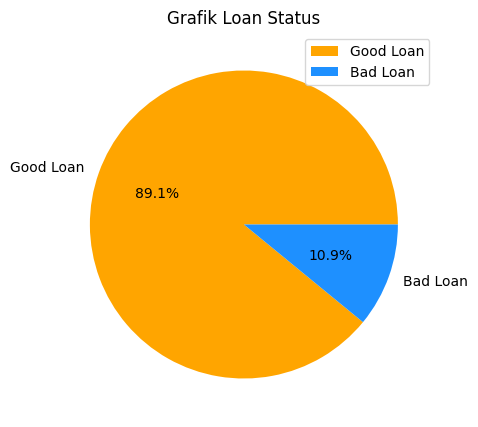

In [20]:
df_loan = df['bad_loan'].map({0: 'Good Loan', 1: 'Bad Loan'})
count_pie = df_loan.value_counts()
index_pie = count_pie.index
value_pie = count_pie.values

fig = plt.figure(figsize=(5, 5))
plt.pie(value_pie, labels=index_pie, autopct='%1.1f%%', colors=['orange','dodgerblue'])

plt.title('Grafik Loan Status')
plt.legend(index_pie)
plt.show()

Saat dipresentasikan dalam bentuk pie chart, bahwa status good loan dengan persentase sebesar 89.1% dan bad loan dengan persentase sebesar 10.9%.

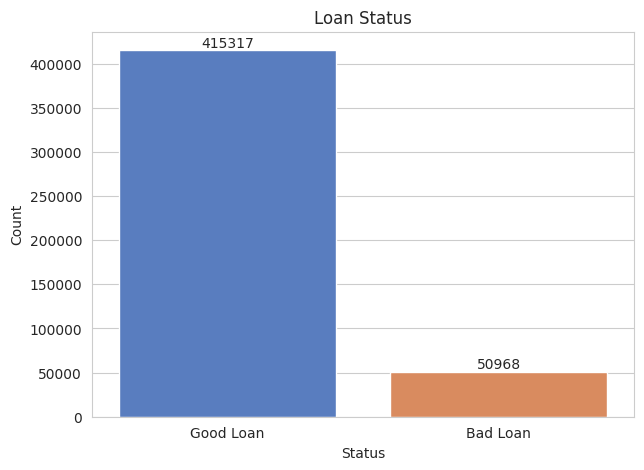

In [21]:
df_loan_bar = df['bad_loan'].map({0: 'Good Loan', 1: 'Bad Loan'})
count_bar = df_loan_bar.value_counts()
index_bar = count_bar.index
value_bar = count_bar.values

sns.set_style('whitegrid')

plt.figure(figsize=(7, 5))
sns.barplot(x=index_bar, y=value_bar, palette='muted')

#enumerate label
for i, v in enumerate(value_bar):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.title('Loan Status')
plt.xlabel('Status')
plt.ylabel('Count')

plt.show()

## Numerical Variables

In [22]:
#numerical
num_data = df.select_dtypes(exclude= 'object')
num_data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'bad_loan'],
      dtype='object')

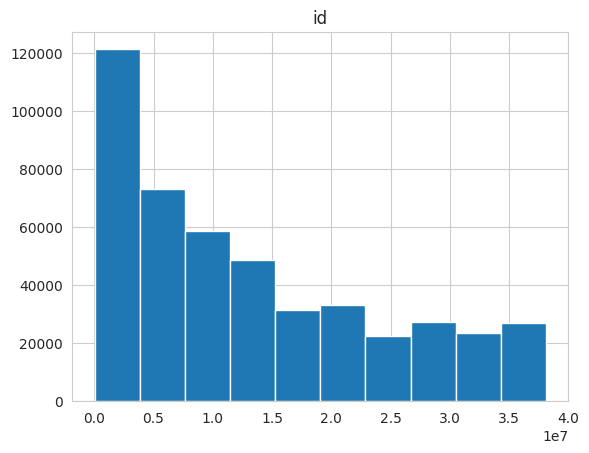

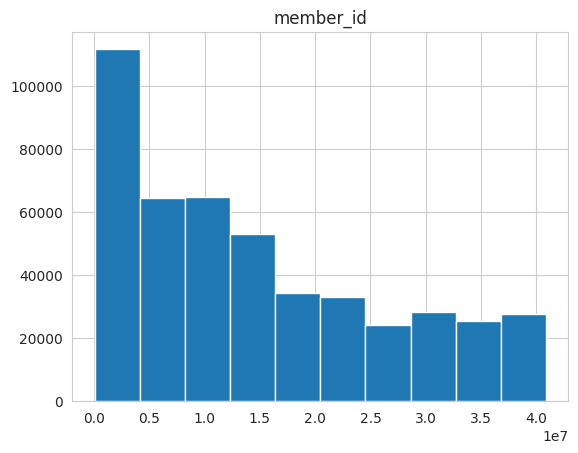

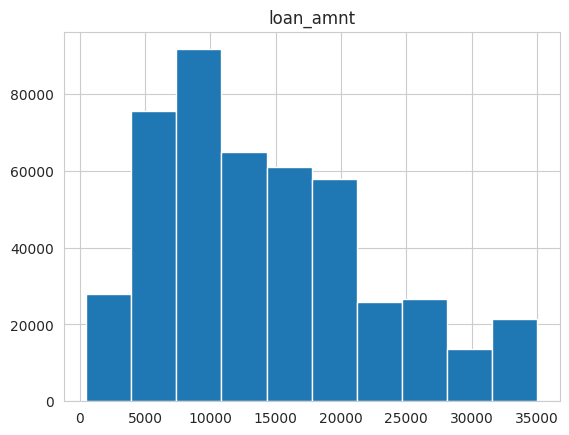

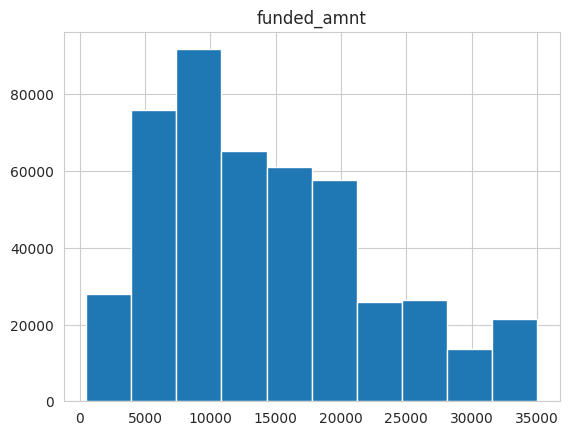

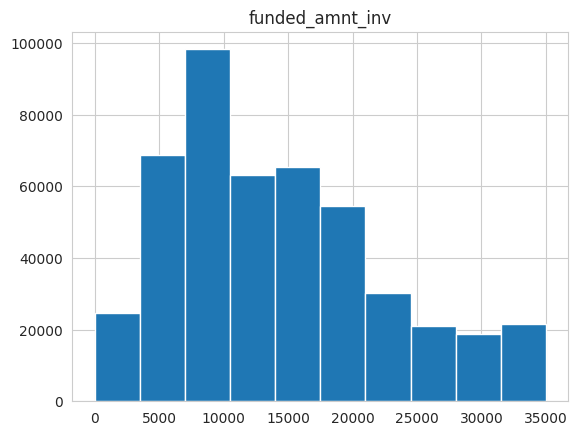

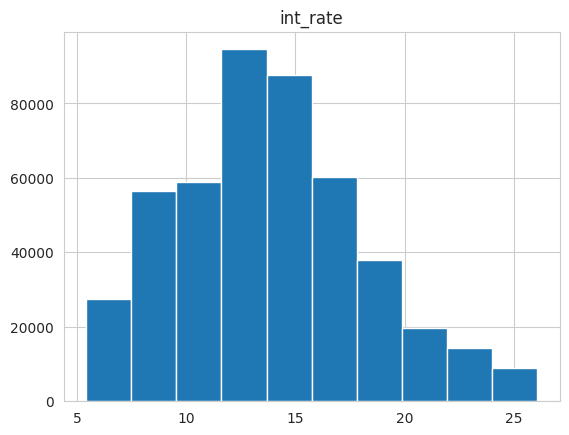

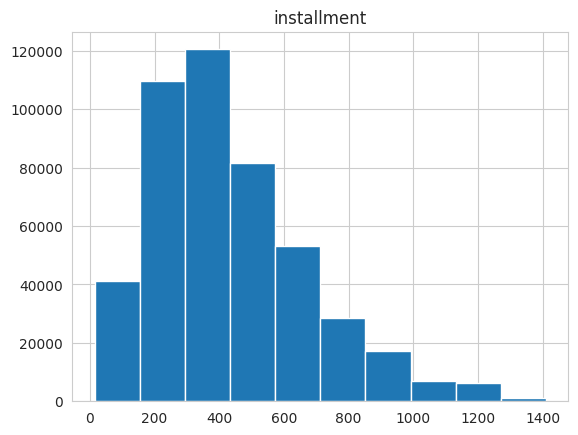

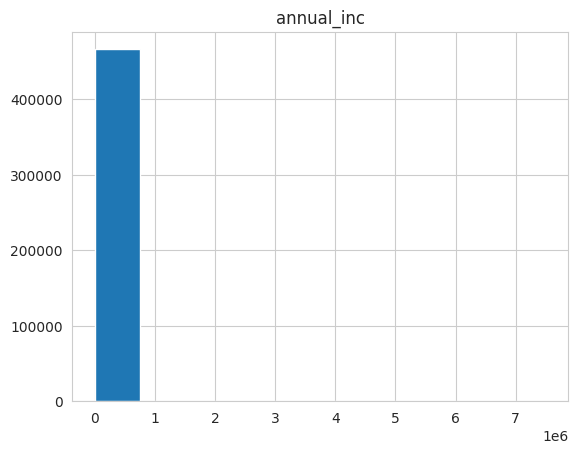

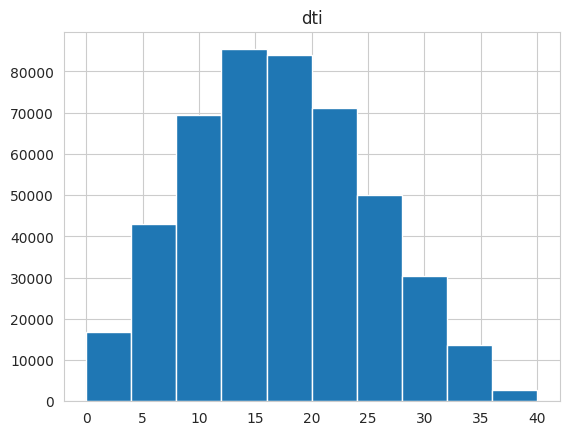

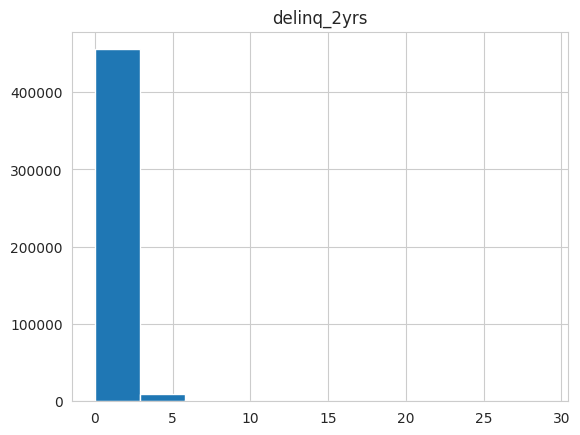

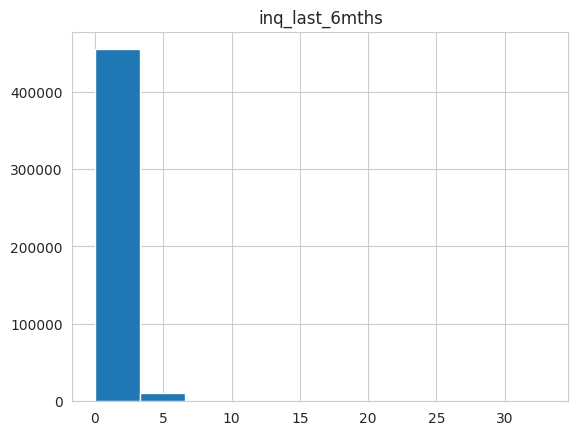

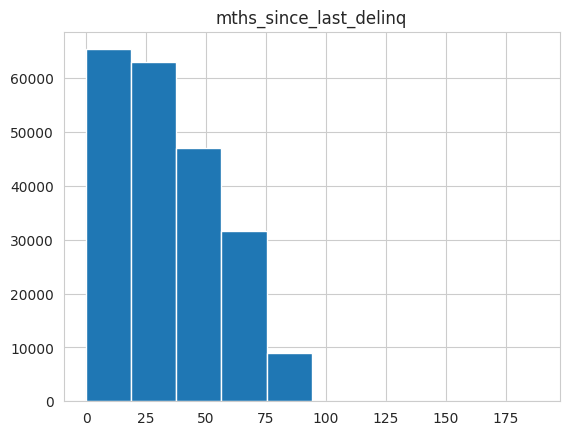

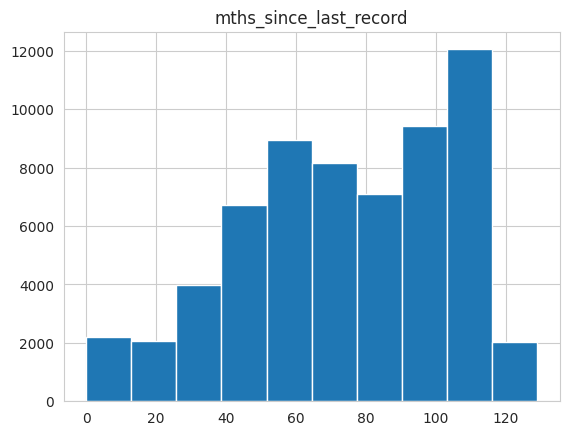

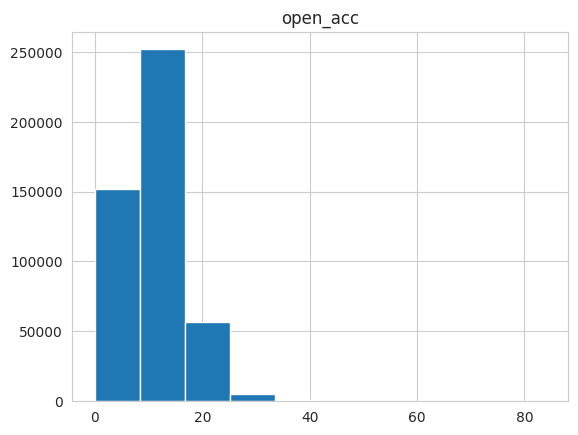

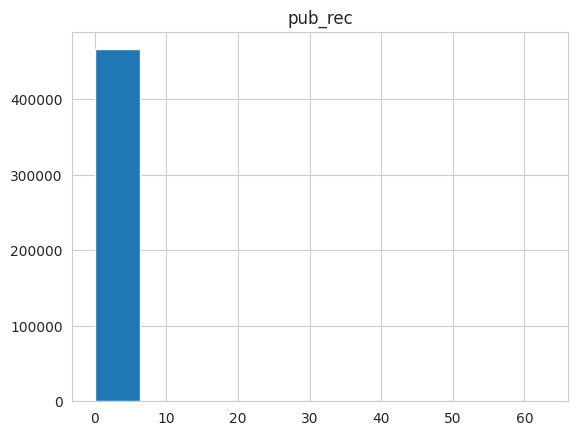

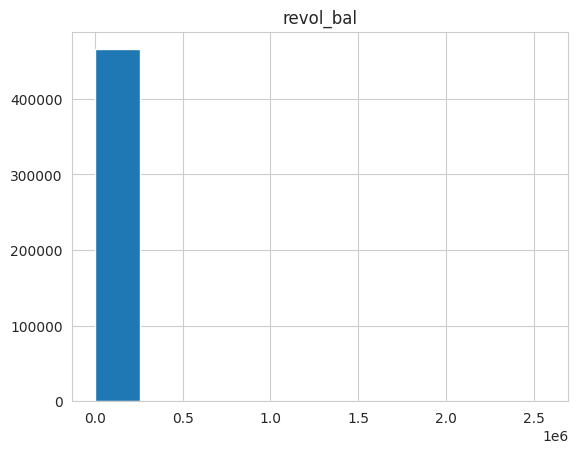

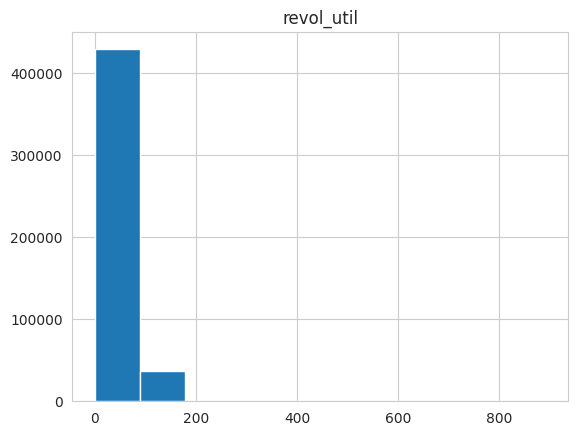

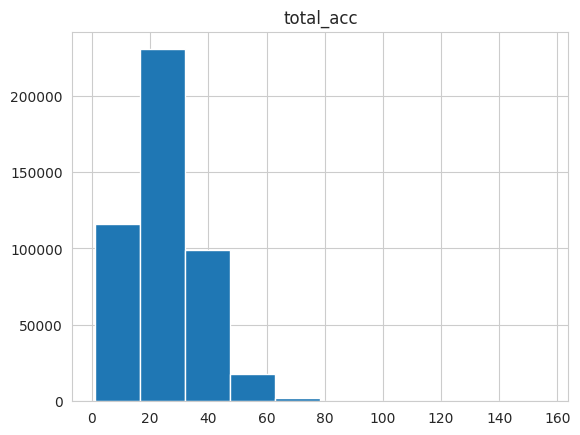

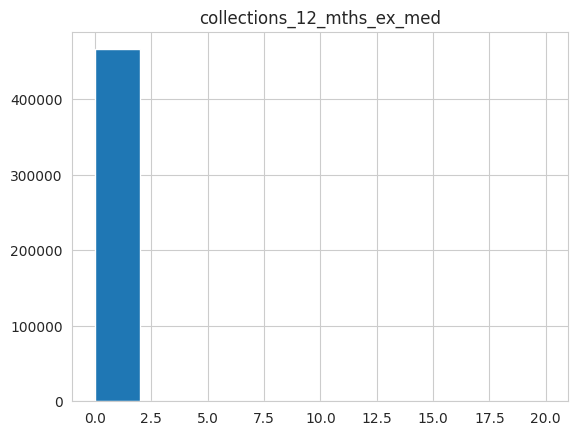

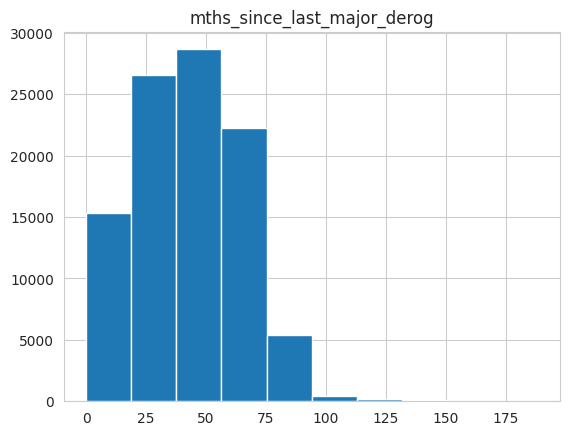

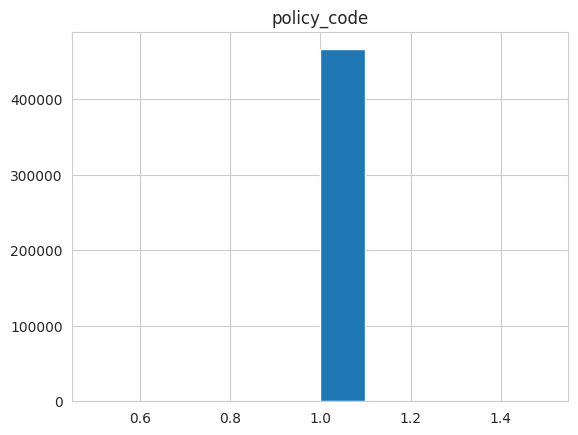

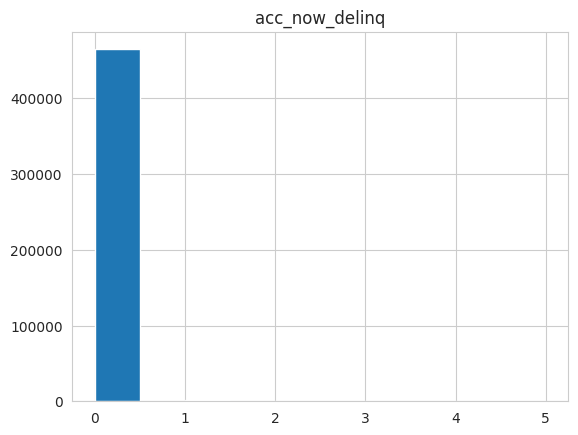

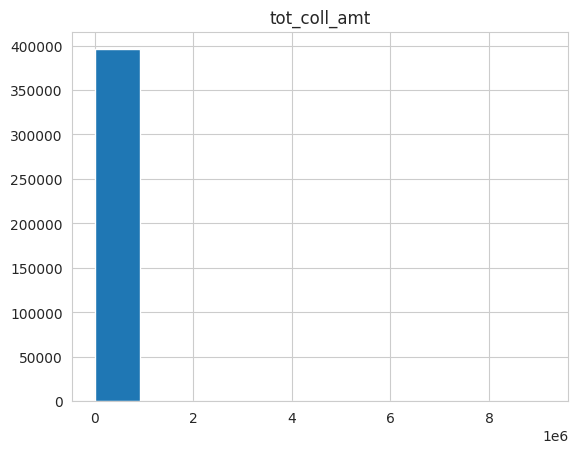

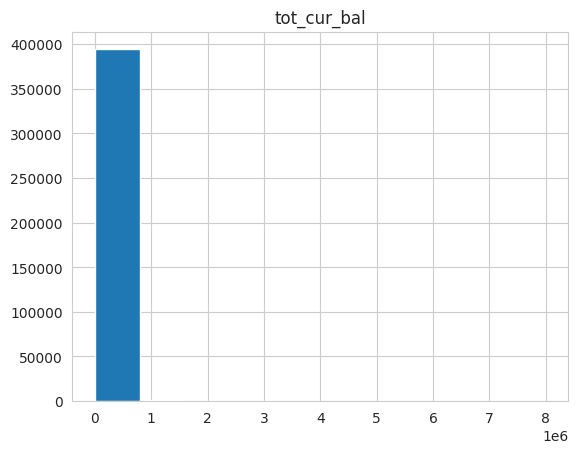

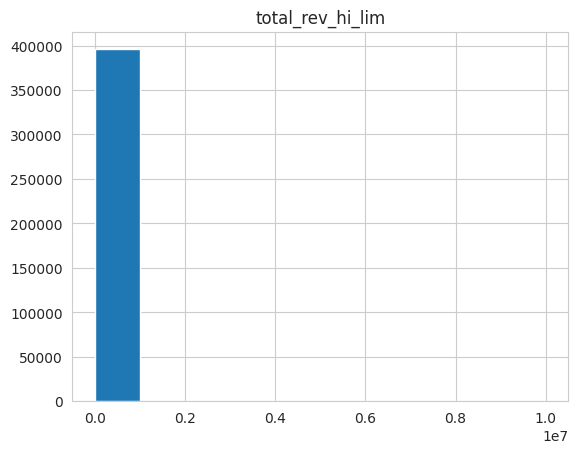

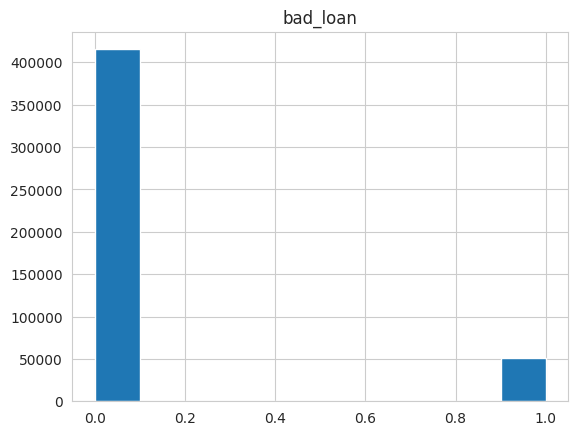

In [23]:
for i in num_data.columns:
    plt.hist(num_data[i])
    plt.title(i)
    plt.show()

## Categorical Variables

In [24]:
#menampilkan data dengan tipe object
df.describe(include = 'O').T

,count,unique,top,freq
term,466285,2,36 months,337953
grade,466285,7,B,136929
sub_grade,466285,35,B3,31686
emp_title,438697,205475,Teacher,5399
emp_length,445277,11,10+ years,150049
home_ownership,466285,6,MORTGAGE,235875
verification_status,466285,3,Verified,168055
url,466285,466285,https://www.lendingclub.com/browse/loanDetail....,1
desc,125981,124435,,234
purpose,466285,14,debt_consolidation,274195


Beberapa tabel dengan tipe data object dikategorikan seabgai variabel kategorikal. Variabel-variabel tersebut bernilai non-numerik dan dilakukan analisa sebagai berikut.

In [25]:
def bar_chart_desc(column, title=None, xlabel=None, ylabel=None):
    count_bar_desc = df[column].value_counts()
    index_bar_desc = count_bar_desc.index
    value_bar_desc = count_bar_desc.values

    sns.set_style('whitegrid')

    fig = plt.figure(figsize=(5, 3))
    sns.barplot(x=index_bar_desc, y=value_bar_desc, order=index_bar_desc, palette='muted')

    for i, v in enumerate(value_bar_desc):
        plt.text(i, v, str(v), ha='center', va='bottom')

    if title:
      plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.show()

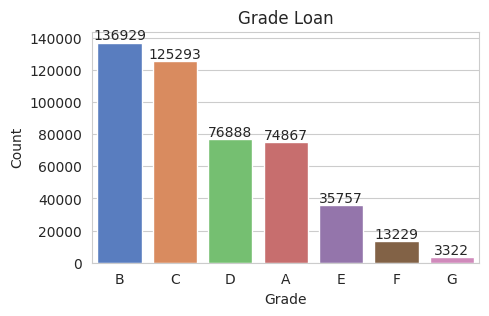

In [26]:
bar_chart_desc('grade', 'Grade Loan', 'Grade', 'Count')

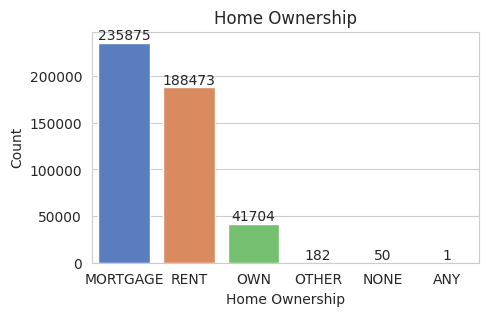

In [27]:
bar_chart_desc('home_ownership', 'Home Ownership', 'Home Ownership', 'Count' )

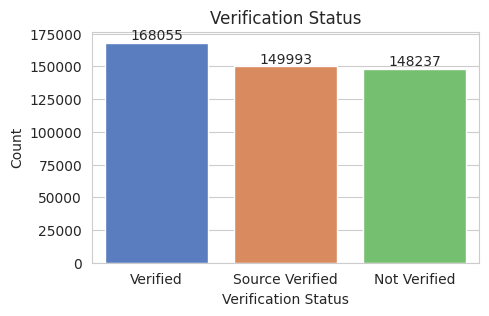

In [28]:
bar_chart_desc('verification_status', 'Verification Status', 'Verification Status', 'Count')

In [29]:
def stacked_bar(column, title=None, xlabel=None, ylabel=None):

    grouped = df.groupby([df[column], df['bad_loan']]).size().unstack(fill_value=0)

    # Plotting
    ax = grouped.plot(kind='bar', stacked=True, figsize=(7,4))

    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

    ax.legend(title='Loan Status', labels=['Good Loan', 'Bad Loan'], loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.tight_layout()
    plt.show()

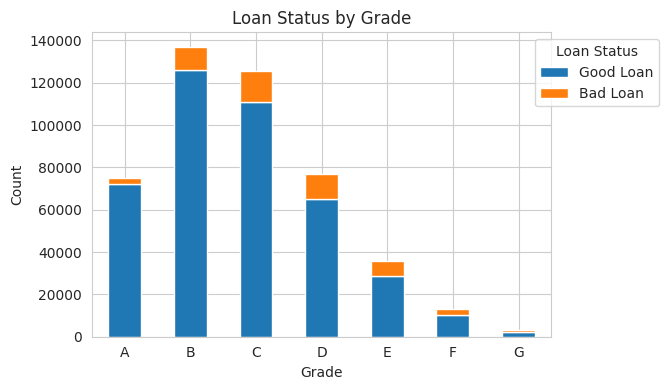

In [30]:
stacked_bar('grade', 'Loan Status by Grade', 'Grade', 'Count')

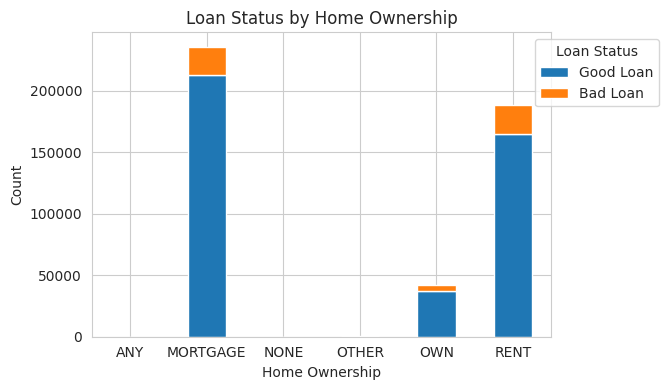

In [31]:
stacked_bar('home_ownership', 'Loan Status by Home Ownership', 'Home Ownership', 'Count')

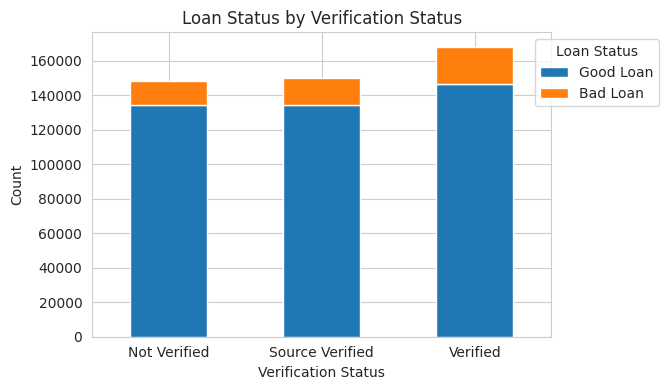

In [32]:
stacked_bar('verification_status', 'Loan Status by Verification Status', 'Verification Status', 'Count')

#Data Preparation

Pada tahap ini beberapa hal yang dilakukan:
1. Variabel dengan missing value > 70% akan dibuang.
2. Variabel id, member id, url, title, desc, zipcode dan emp_title tidak digunakan.
3. Variabel sub_grade tidak digunakan karena sudah diwakili oleh variabel grade.
4. Variabel yang memiliki informasi mengenai masa yang belum terjadi seperti next_pymnt_d, recoveries, collection_recovery_fee, total_rec_prncp dan total_rec_late_fee tidak digunakan.

## Parsing Data

### Parsing: emp_length

In [33]:
df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

Pada variabel emp_length merupakan lama atau durasi peminjam bekerja. Pada variabel tersebut nilai perlu dilakukan parsing agar menjadi satuan yang baku, misalnya dirubah menjadi format data angka.

In [34]:
def emp_length_convert(df, column):
    df[column] = df[column].str.replace(' years', '').str.replace('+', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)


emp_length_convert(df, 'emp_length')

df['emp_length'].unique()

array([10.,  0.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7.])

In [35]:
df['emp_length'].sample(5)

359662     7.0
291463     4.0
392894    10.0
162098    10.0
300670    10.0
Name: emp_length, dtype: float64

### Parsing: term

In [36]:
def term_numeric(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

term_numeric(df, 'term')

In [37]:
df['term'].sample(5)

52618     60
211989    36
70302     60
388622    36
296478    36
Name: term, dtype: int64

### Parsing: dates

In [38]:
def date_columns(df, column):
    #Mengatur tanggal referensi
    today_date = pd.to_datetime('2016-01-01')

    #konversi ke format date time
    df[column] = pd.to_datetime(df[column], format = "%b-%y")

    #kalkulasi selisih bulan dan membuat kolom baru
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))

    #Membuat hasil yang bernilai negatif menjadi nilai maksimum
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)

    df.drop(columns = [column], inplace = True)

In [39]:
date_columns(df, 'last_credit_pull_d')

In [40]:
date_columns(df, 'earliest_cr_line')

Memodifikasi tanggal-tanggal pada variabel issue_d, last_payment_d, last_credit_pull_d dan earliest_cr_line dari format bulan-tahun menjadi perhitungan berapa lama waktu sejak waktu tersebut dalam bulan. Untuk itu perlu ditentukan tanggal referensi sebagai acuan. Karena dataset yang digunakan yakni dataset tahun 2007-2014, penggunaan tanggal 2016-1-1 menjadi lebih relevan.

## Missing value

In [41]:
total_rows = len(df)
missing_val = (df.isnull().sum() / total_rows * 100).sort_values(ascending=False)
print(missing_val[missing_val>70].to_string())

mths_since_last_record         86.566585
mths_since_last_major_derog    78.773926
desc                           72.981975


In [42]:
columns_to_drop = ['mths_since_last_record', 'mths_since_last_major_derog', 'desc']
df.drop(columns=columns_to_drop, inplace=True, axis=1)

In [43]:
string_null = df.isnull().sum().sort_values(ascending=False)
print(string_null.to_string())

mths_since_last_delinq           250351
total_rev_hi_lim                  70276
tot_cur_bal                       70276
tot_coll_amt                      70276
emp_title                         27588
revol_util                          340
collections_12_mths_ex_med          145
mths_since_last_credit_pull_d        42
total_acc                            29
open_acc                             29
pub_rec                              29
mths_since_earliest_cr_line          29
inq_last_6mths                       29
acc_now_delinq                       29
delinq_2yrs                          29
title                                21
annual_inc                            4
initial_list_status                   0
policy_code                           0
revol_bal                             0
application_type                      0
bad_loan                              0
id                                    0
member_id                             0
grade                                 0


In [44]:
num_data = df.select_dtypes(exclude= 'object')
num_data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'bad_loan',
       'mths_since_last_credit_pull_d', 'mths_since_earliest_cr_line'],
      dtype='object')

In [45]:
cat_data = df.select_dtypes(include= 'object')
cat_data.columns

Index(['grade', 'sub_grade', 'emp_title', 'home_ownership',
       'verification_status', 'url', 'purpose', 'title', 'zip_code',
       'addr_state', 'initial_list_status', 'application_type'],
      dtype='object')

In [46]:
#missing handle for numerical
df['annual_inc'].fillna(df['annual_inc'].mean(), inplace=True)
df['mths_since_earliest_cr_line'].fillna(0, inplace=True)
df['mths_since_last_credit_pull_d'].fillna(0, inplace=True)
df['acc_now_delinq'].fillna(0, inplace=True)
df['total_acc'].fillna(0, inplace=True)
df['pub_rec'].fillna(0, inplace=True)
df['open_acc'].fillna(0, inplace=True)
df['inq_last_6mths'].fillna(0, inplace=True)
df['delinq_2yrs'].fillna(0, inplace=True)
df['collections_12_mths_ex_med'].fillna(0, inplace=True)
df['revol_util'].fillna(0, inplace=True)
df['tot_cur_bal'].fillna(0, inplace=True)
df['tot_coll_amt'].fillna(0, inplace=True)
df['total_rev_hi_lim'].fillna(0, inplace=True)
df['mths_since_last_delinq'].fillna(-1, inplace=True)

#missing handle for categorical
df['emp_title'].fillna(df['emp_title'].mode()[0], inplace=True)
df['title'].fillna(df['title'].mode()[0], inplace=True)

In [47]:
string_null = df.isnull().sum().sort_values(ascending=False)
print(string_null.to_string())

id                               0
member_id                        0
inq_last_6mths                   0
mths_since_last_delinq           0
open_acc                         0
pub_rec                          0
revol_bal                        0
revol_util                       0
total_acc                        0
initial_list_status              0
collections_12_mths_ex_med       0
policy_code                      0
application_type                 0
acc_now_delinq                   0
tot_coll_amt                     0
tot_cur_bal                      0
total_rev_hi_lim                 0
bad_loan                         0
mths_since_last_credit_pull_d    0
delinq_2yrs                      0
dti                              0
addr_state                       0
sub_grade                        0
loan_amnt                        0
funded_amnt                      0
funded_amnt_inv                  0
term                             0
int_rate                         0
installment         

## Feature Selection

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 466285 entries, 0 to 466284
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             466285 non-null  int64  
 1   member_id                      466285 non-null  int64  
 2   loan_amnt                      466285 non-null  int64  
 3   funded_amnt                    466285 non-null  int64  
 4   funded_amnt_inv                466285 non-null  float64
 5   term                           466285 non-null  int64  
 6   int_rate                       466285 non-null  float64
 7   installment                    466285 non-null  float64
 8   grade                          466285 non-null  object 
 9   sub_grade                      466285 non-null  object 
 10  emp_title                      466285 non-null  object 
 11  emp_length                     466285 non-null  float64
 12  home_ownership                 4662

### Remove Variable with Hight Similiarity

In [49]:
df.nunique()[df.nunique() < 10].sort_values()

policy_code                   1
application_type              1
term                          2
initial_list_status           2
bad_loan                      2
verification_status           3
home_ownership                6
acc_now_delinq                6
grade                         7
collections_12_mths_ex_med    9
dtype: int64

### Remove Variable Not Relevant

In [50]:
columns_to_drop = ['url', 'member_id','id','sub_grade', 'title', 'zip_code', 'policy_code', 'emp_title', 'application_type']
df.drop(columns=columns_to_drop, inplace=True, axis=1)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 466285 entries, 0 to 466284
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      466285 non-null  int64  
 1   funded_amnt                    466285 non-null  int64  
 2   funded_amnt_inv                466285 non-null  float64
 3   term                           466285 non-null  int64  
 4   int_rate                       466285 non-null  float64
 5   installment                    466285 non-null  float64
 6   grade                          466285 non-null  object 
 7   emp_length                     466285 non-null  float64
 8   home_ownership                 466285 non-null  object 
 9   annual_inc                     466285 non-null  float64
 10  verification_status            466285 non-null  object 
 11  purpose                        466285 non-null  object 
 12  addr_state                     4662

In [52]:
#numerical
num_data = df.select_dtypes(exclude= 'object')
num_data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'bad_loan', 'mths_since_last_credit_pull_d',
       'mths_since_earliest_cr_line'],
      dtype='object')

In [53]:
cat_data = df.select_dtypes(include= 'object')
cat_data.columns

Index(['grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state', 'initial_list_status'],
      dtype='object')

### Correlation Check

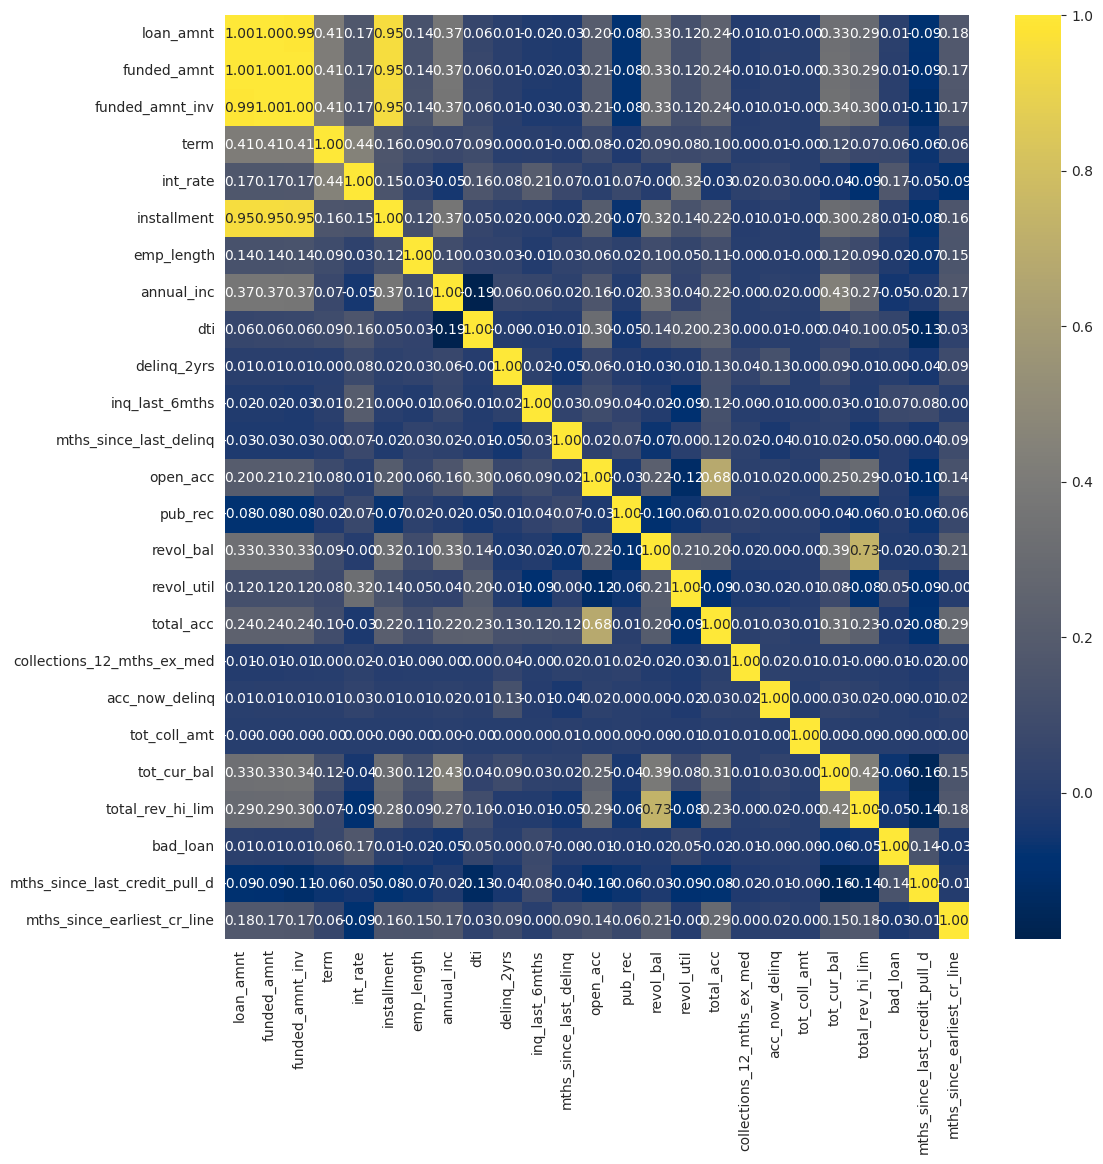

In [54]:
corrMatrix = num_data.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrMatrix, annot=True, fmt=".2f", cmap="cividis")
plt.show()

In [55]:
columns_to_drop = ['loan_amnt','funded_amnt','funded_amnt_inv']
df.drop(columns=columns_to_drop, inplace=True, axis=1)

Variebel (kolom) yang memiliki korelasi yang berlebih terhadap variabel lain, bukan terhadap label akan dihilangkan.

### Feature Encode

In [56]:
df['grade'].value_counts()

grade
B    136929
C    125293
D     76888
A     74867
E     35757
F     13229
G      3322
Name: count, dtype: int64

In [57]:
grade_map = {
    'A' : 1,
    'B' : 2,
    'C' : 3,
    'D' : 4,
    'E' : 5,
    'F' : 6,
    'G' : 7,
}

cat_data['grade'] = cat_data['grade'].map(grade_map)

In [58]:
to_dummies = ['home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status']

dummies = pd.get_dummies(cat_data[to_dummies])
dummies.drop('initial_list_status_w', axis=1, inplace=True)

In [59]:
dummies.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,...,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f
0,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True


In [60]:
# drop kolom yang sudah di one encoded
cat_data.drop(to_dummies, axis=1, inplace=True)

In [61]:
# gabungkan kategorical dengan one hot encoded
cat_data_f = pd.concat([cat_data, dummies], axis = 1)

In [62]:
num_data = df.select_dtypes(exclude= 'object')
num_data.columns

Index(['term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'bad_loan',
       'mths_since_last_credit_pull_d', 'mths_since_earliest_cr_line'],
      dtype='object')

In [63]:
final_data = pd.concat([num_data, cat_data_f], axis = 1).dropna().reset_index().drop('index', axis = 1)
final_data.head()

,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,...,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f
0,36,10.65,162.87,10.0,24000.0,27.65,0.0,1.0,-1.0,3.0,...,False,False,False,False,False,False,False,False,False,True
1,60,15.27,59.83,0.0,30000.0,1.00,0.0,5.0,-1.0,3.0,...,False,False,False,False,False,False,False,False,False,True
2,36,15.96,84.33,10.0,12252.0,8.72,0.0,2.0,-1.0,2.0,...,False,False,False,False,False,False,False,False,False,True
3,36,13.49,339.31,10.0,49200.0,20.00,0.0,1.0,35.0,10.0,...,False,False,False,False,False,False,False,False,False,True
4,60,12.69,67.79,1.0,80000.0,17.94,0.0,0.0,38.0,15.0,...,False,False,False,False,False,False,False,False,False,True


### Outlier Check with IQR

In [64]:
num_data = final_data.select_dtypes(exclude= 'object')
num_data.columns

Index(['term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'bad_loan',
       'mths_since_last_credit_pull_d', 'mths_since_earliest_cr_line', 'grade',
       'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       '

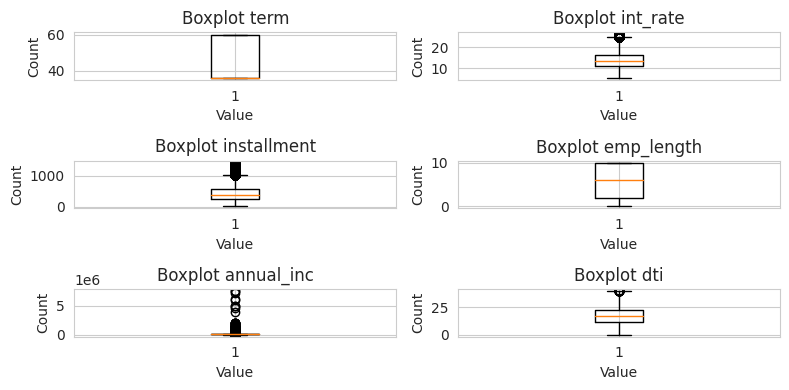

In [65]:
numeric =['term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti']

num_plots = len(numeric)
rows = (num_plots + 1)//2
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(8, 4))

for i, column in enumerate(numeric):
    ax = axes.flatten()[i]
    ax.boxplot(df[column])
    ax.set_title(f'Boxplot {column}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [66]:
print(f'Jumlah baris sebelum memfilter outlier: {len(final_data)}')

filtered_entries = np.array([True] * len(final_data))
for col in ['term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti']:
    Q1 = final_data[col].quantile(0.25)
    Q3 = final_data[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((final_data[col] >= low_limit) & (final_data[col] <= high_limit)) & filtered_entries

final_data = final_data[filtered_entries]

print(f'Jumlah baris setelah memfilter outlier: {len(final_data)}')

Jumlah baris sebelum memfilter outlier: 466285
Jumlah baris setelah memfilter outlier: 433236


# Modeling

In [67]:
X = final_data.drop('bad_loan', axis = 1)
y = final_data['bad_loan']

In [68]:
from collections import Counter

print(Counter(y))

Counter({0: 385798, 1: 47438})


In [69]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=123)
X,y = smote.fit_resample(X,y)
print(Counter(y))

Counter({0: 385798, 1: 385798})


In [70]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

## Decision Tree

In [71]:
param_grid = {
    'criterion':['gini', 'entropy'],
    'splitter':['best','random'],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [73]:
from sklearn.tree import DecisionTreeClassifier

dcs_tree = DecisionTreeClassifier()

grid_search = GridSearchCV(dcs_tree, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Parameter terbaik:", grid_search.best_params_)

best_dcs_tree = grid_search.best_estimator_

y_pred = best_dcs_tree.predict(X_test)
accuracy_dcs = accuracy_score(y_test, y_pred)

print("Akurasi Model:", accuracy_dcs)
print("Akurasi Model: {:.2%}".format(accuracy_dcs))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Parameter terbaik: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Akurasi Model: 0.8231329839855883
Akurasi Model: 82.31%
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83    115553
           1       0.85      0.78      0.82    115926

    accuracy                           0.82    231479
   macro avg       0.83      0.82      0.82    231479
weighted avg       0.83      0.82      0.82    231479



### Logistic Regression

In [77]:
param_grid = {
    'C': [0.001, 0.01, 0.1]
}

In [78]:
logreg = LogisticRegression()

grid_search_logreg = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')

grid_search_logreg.fit(X_train, y_train)

print("Best Parameter:", grid_search_logreg.best_params_)

best_logreg = grid_search_logreg.best_estimator_

y_pred_logreg = best_logreg.predict(X_test)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print("Akurasi Model:", accuracy_logreg)
print("Akurasi Model: {:.2%}".format(accuracy_logreg))
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))

Best Parameter: {'C': 0.1}
Akurasi Model: 0.6028322223614238
Akurasi Model: 60.28%
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.51      0.56    115553
           1       0.59      0.69      0.64    115926

    accuracy                           0.60    231479
   macro avg       0.61      0.60      0.60    231479
weighted avg       0.61      0.60      0.60    231479



## Conclution

| No  | Algoritma       | Akurasi | Precision | Recall | F-Score |
|-----|-----------------|---------|-----------|--------|---------|
| 1   | Decision Tree   | 0.82  |      0.85     |   0.78     |    0.82     |
| 2   | Logistic Regression   | 0.60  |     0.59      |    0.69    |   0.64      |


Dari hasil evaluasi matriks tersebut, dapat disimpulkan bahwa model Decision Tree memiliki hasil yang lebih optimal dengan akurasi sebesar 0.82; precision sebesar 0.85; recall sebesar 0.78 dan F1-Score sebesar 0.82. Meskipun Logistic Regression dilakukan parameter tunning, namun hasilnya belum optimal.